In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
import time

## Create the evaluation function

In [116]:
# Function for feature selection version 1
def feature_selection(X, Y):
    f, p = f_classif(X, Y)
    corr_df = pd.DataFrame({'features': X.columns, 'f_val': f, 'p_val': p})
    # using the 3 level significance test 
    # (***: p_val < 0.001, **: p_val < 0.01, *: p_val < 0.05)
    # we will select the features with p_val < 0.05
    p_tr = 0.001
    relevant_features = corr_df.loc[corr_df['p_val'] < p_tr, "features"].tolist()
    # print(f"There are {len(relevant_features)} relevant features and they are: {relevant_features}")
    
    return relevant_features

I created a feature selection function that includes different selection methods:

In [117]:
# Function for feature selection version 2
def select_features(X, y, method, corr_threshold=0.5):
    
    if method is None:
        return X.columns
        
    # Feature selection using chi-squared
    elif method == 'p-value':
        # Remove constant features
        X = X.loc[:, X.apply(pd.Series.nunique) != 1]
        p_values = []
        for feature in X.columns:
            f, p = chi2(X[[feature]], y)
            p_values.append(p)

        p_values = np.array(p_values).reshape(-1)
        p_values = pd.Series(p_values, index=X.columns).sort_values()
        selected_features = p_values[p_values < 0.05].index
    
    # Feature selection using VarianceThreshold
    elif method == 'variance':
        X = X.loc[:, X.apply(pd.Series.nunique) != 1]
        var_thr = VarianceThreshold(threshold=0.25)
        var_thr.fit(X)
        selected_features = X.columns[var_thr.get_support()]  
    
    # Feature selection using Pearson correlation
    elif method == 'correlation':
        X = X.loc[:, X.apply(pd.Series.nunique) != 1]
        corr = X.corr()
        col_corr = set()

        corr_matrix = np.abs(corr.values)

        n = corr_matrix.shape[0]

        for i in range(n):
            for j in range(i):
                if corr_matrix[i, j] > corr_threshold:
                    colname = X.columns[i]
                    col_corr.add(colname)

        selected_features = [col for col in X.columns if col not in col_corr]

    # More methods to be added 
                
    return selected_features

I created a scaling function which includes different scaling methods:

In [118]:
# Function for scaling the data
def scale(X_train, X_test, method):
    
    if method is None:
        return X_train, X_test

    # Scaling using StandardScaler 
    elif method == 'standard':
        scaler = StandardScaler().fit(X_train)

    # Scaling using MinMaxScaler
    elif method == 'minmax':
        scaler = MinMaxScaler().fit(X_train)

    # Scaling using RobustScaler
    elif method == 'robust':
        scaler = RobustScaler().fit(X_train)

    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
                
    return X_train_scaled, X_test_scaled

Time measurements have been added

In [119]:
def evaluate_model(X, Y, feature_selection, scaling, classifier, splitting, folds=5):
    if splitting == "cv":
        kf = KFold(n_splits=folds, shuffle=True, random_state=18)
        metric_results = {}
        #do the KFold cross validation
        for train_index, test_index in kf.split(X,Y):
            # split the data into train and test for this fold
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]   
            
            # preprocess the data
            # feature selection
            preprocess_start_time = time.time()
            rel_features = select_features(X_train, y_train, feature_selection)
            n_features_orig = X_train.shape[1]
            n_features = len(rel_features)
            preprocess_end_time = time.time()
            preprocess_time = preprocess_end_time - preprocess_start_time

            # scaling the data
            X_train_preprocessed, X_test_preprocessed = scale(X_train[rel_features], X_test[rel_features], scaling)

            """ if preprocess == "none":
                X_train_preprocessed = X_train
                X_test_preprocessed = X_test
            elif preprocess == "featureselection":
                # sig_selector = VarianceThreshold(threshold=0.4)
                # X_train_preprocessed = sig_selector.fit_transform(X_train)
                # X_test_preprocessed = sig_selector.transform(X_test)
                rel_features = select_features(X_train, y_train, )
                X_train_preprocessed = X_train[rel_features]
                X_test_preprocessed = X_test[rel_features]
            else:
                scaler = StandardScaler()
                X_train_preprocessed = scaler.fit_transform(X_train)
                X_test_preprocessed = scaler.transform(X_test) """
                
            # train and evaluate the model
            clf = classifier
            train_start_time = time.time()
            clf.fit(X_train_preprocessed, y_train)
            train_end_time = time.time()
            training_time = train_end_time - train_start_time
            
            pred_start_time = time.time()
            Y_pred_fold = clf.predict(X_test_preprocessed)
            pred_end_time = time.time()
            prediction_time = pred_end_time - pred_start_time
                
            # calculate the accuracy, precision, recall and f1 score per fold
            accuracy = metrics.accuracy_score(y_test, Y_pred_fold)
            precision = metrics.precision_score(y_test, Y_pred_fold, average='weighted')
            recall = metrics.recall_score(y_test, Y_pred_fold, average='weighted')
            f1 = metrics.f1_score(y_test, Y_pred_fold, average='weighted')

            # add the scores to the dict
            metric_results.setdefault('accuracy', []).append(accuracy)
            metric_results.setdefault('precision', []).append(precision)
            metric_results.setdefault('recall', []).append(recall)
            metric_results.setdefault('f1', []).append(f1)
            metric_results.setdefault('training_time', []).append(training_time)
            metric_results.setdefault('prediction_time', []).append(prediction_time)
            metric_results.setdefault('preprocess_time', []).append(preprocess_time)
            
            
        # Calculate the mean of the metrics over all folds
        accuracy_mean = np.mean(metric_results['accuracy'])
        precision_mean = np.mean(metric_results['precision'])
        recall_mean = np.mean(metric_results['recall'])
        f1_mean = np.mean(metric_results['f1'])
        training_time_mean = np.mean(metric_results['training_time'])
        prediction_time_mean = np.mean(metric_results['prediction_time'])
        preprocess_time_mean = np.mean(metric_results['preprocess_time'])
        
        # Calculate the standard deviation of f1
        f1_std = np.std(metric_results['f1'])

        return {'classifier': classifier.__class__.__name__, 'splitting': splitting, 'feature_selection': feature_selection, 'scaling': scaling, 'n_features_orig': n_features_orig, 'n_features': n_features, 'accuracy': accuracy_mean, 'precision': precision_mean, 'recall': recall_mean, 'f1': f1_mean, 'f1_std': f1_std, 'preprocess_time': preprocess_time_mean,'training_time': training_time_mean, 'prediction_time': prediction_time_mean}

    elif splitting == "holdout":
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=18)
        
        # preprocess the data
        # feature selection
        preprocess_start_time = time.time()
        rel_features = select_features(X_train, y_train, feature_selection)
        n_features_orig = X_train.shape[1]
        n_features = len(rel_features)
        preprocess_end_time = time.time()
        preprocess_time = preprocess_end_time - preprocess_start_time


        # scaling the data
        X_train_preprocessed, X_test_preprocessed = scale(X_train[rel_features], X_test[rel_features], scaling)

        # train and evaluate the model
        clf = classifier
        train_start_time = time.time()
        clf.fit(X_train_preprocessed, y_train)
        train_end_time = time.time()
        training_time = train_end_time - train_start_time
        
        pred_start_time = time.time()
        Y_pred = clf.predict(X_test_preprocessed)
        pred_end_time = time.time()
        prediction_time = pred_end_time - pred_start_time

        # calculate the accuracy, precision, recall and f1 score per fold
        accuracy = metrics.accuracy_score(y_test, Y_pred)
        precision = metrics.precision_score(y_test, Y_pred, average='weighted')
        recall = metrics.recall_score(y_test, Y_pred, average='weighted')
        f1 = metrics.f1_score(y_test, Y_pred, average='weighted')

        return {'classifier': classifier.__class__.__name__, 'splitting': splitting, 'feature_selection': feature_selection, 'scaling': scaling, 'n_features_orig': n_features_orig, 'n_features': n_features, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'preprocess_time': preprocess_time,'training_time': training_time, 'prediction_time': prediction_time}
    

### Smote function for balancing class column

For those datasets that have an imbalanced response variable the smote method can be implimented to compensate for the class imbalance in the data

In [120]:
def apply_smote(df, target_column, k_neighbors=4, random_state=321):

    X = df.drop(target_column, axis=1)
    y = df[target_column]

    sm = SMOTE(random_state=random_state, k_neighbors=k_neighbors)
    X_resampled, y_resampled = sm.fit_resample(X, y)

    return X_resampled, y_resampled

## Load the data



### Congressional voting
An iterativ imputation has been already done on the data.

In [121]:
test_df = pd.read_csv("./preprocessed-datasets/CongressionVoting_prepro.csv")
test_df.set_index('ID', inplace=True)
test_df_X = test_df.drop(columns=["class"])
test_df_Y = test_df["class"]

## Evaluation

The **evaluate_model** function takes:
* the input feature (*X*),
* the dependent variable (*Y*)
* the preprocessing method as a string:
    * the so far implemented possible options can be found in the *preprocess_options* list. Here *else* is implemented as the *StandardScaler()*, however it could be combined with additional feature selection to achieve a better result.
* classifier as a function:
    * so far the only tried one is *SVC(C=3, kernel='sigmoid')*
* folds to define the number of  folds. The default value is 5.

In [122]:
#preprocess_options = ["none", "featureselection", "else"]

The changed evaluate_model function is the following:
* takes the input feature and the dependent variable
* splits the data into train and test set
* preprocesses the data
    * feature selection
    * scaling 
* trains the classifier on the train set

In [123]:
evaluate_model(test_df_X, test_df_Y, None, "standard", SVC(C=3, kernel='sigmoid'), splitting="cv")

{'classifier': 'SVC',
 'splitting': 'cv',
 'feature_selection': None,
 'scaling': 'standard',
 'n_features_orig': 16,
 'n_features': 16,
 'accuracy': 0.9539112050739957,
 'precision': 0.9550828119249172,
 'recall': 0.9539112050739957,
 'f1': 0.9536452231720876,
 'f1_std': 0.02997516371593895,
 'preprocess_time': 5.340576171875e-06,
 'training_time': 0.0019176483154296875,
 'prediction_time': 0.0004981517791748047}

## Experimeting a bit

Loading the datasets

In [124]:
bank_marketing = pd.read_csv("./preprocessed-datasets/bank_marketing_prepro.csv")
bank_marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     41188 non-null  int64  
 1   age                            41188 non-null  float64
 2   default                        41188 non-null  float64
 3   housing                        41188 non-null  float64
 4   loan                           41188 non-null  float64
 5   campaign                       41188 non-null  float64
 6   pdays                          41188 non-null  float64
 7   previous                       41188 non-null  float64
 8   emp.var.rate                   41188 non-null  float64
 9   cons.price.idx                 41188 non-null  float64
 10  cons.conf.idx                  41188 non-null  float64
 11  euribor3m                      41188 non-null  float64
 12  nr.employed                    41188 non-null 

In [125]:
wine_quality = pd.read_csv("./preprocessed-datasets/wine_quality_prepro.csv")
wine_quality.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            6497 non-null   int64  
 1   fixed acidity         6497 non-null   float64
 2   volatile acidity      6497 non-null   float64
 3   citric acid           6497 non-null   float64
 4   residual sugar        6497 non-null   float64
 5   chlorides             6497 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6497 non-null   float64
 10  sulphates             6497 non-null   float64
 11  alcohol               6497 non-null   float64
 12  class                 6497 non-null   int64  
 13  wine_type             6497 non-null   int64  
dtypes: float64(11), int64(3)
memory usage: 710.7 KB


In [126]:
congression_voting = pd.read_csv("./preprocessed-datasets/CongressionVoting_prepro.csv")
congression_voting.set_index('ID', inplace=True)
congression_voting.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 140 to 324
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   handicapped-infants                     217 non-null    float64
 1   water-project-cost-sharing              217 non-null    float64
 2   adoption-of-the-budget-resolution       217 non-null    float64
 3   physician-fee-freeze                    217 non-null    float64
 4   el-salvador-aid                         217 non-null    float64
 5   religious-groups-in-schools             217 non-null    float64
 6   anti-satellite-test-ban                 217 non-null    float64
 7   aid-to-nicaraguan-contras               217 non-null    float64
 8   mx-missile                              217 non-null    float64
 9   immigration                             217 non-null    float64
 10  synfuels-crporation-cutback             217 non-null    floa

In [127]:
reviews = pd.read_csv("./preprocessed-datasets/Review_prepro.csv")
reviews.set_index('ID', inplace=True)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750 entries, 0 to 749
Columns: 10001 entries, V1 to class
dtypes: int64(10000), object(1)
memory usage: 57.2+ MB


In [128]:
datasets = {
    'wine_quality': wine_quality,
    'reviews': reviews,
    'congression_voting': congression_voting,
    'bank_marketing': bank_marketing
}

feature_selection_methods = ['p-value'] # None , 'variance', 'correlation']
scaling_methods = [None, 'standard'] #, 'minmax', 'robust']
classifiers = [LinearSVC(), DecisionTreeClassifier(),RandomForestClassifier()] #, GaussianNB()]

results = []

for dataset_name, dataset in datasets.items():
    for feature_selection_method in feature_selection_methods:
        for scaling_method in scaling_methods:
            for classifier in classifiers:
                for splitting_method in ["holdout"]: # ,'cv']:
                    if dataset_name == 'wine_quality' or dataset_name == 'bank_marketing':
                        target_column = 'class'
                        X,Y = apply_smote(dataset,target_column)
                    else:
                        X = dataset.drop(columns=["class"])
                        Y = dataset["class"]
                    start_time = time.time()
                    evaluation_result = evaluate_model(X, Y, feature_selection_method, scaling_method, classifier, splitting_method)
                    end_time = time.time()
                    time_taken = end_time - start_time
                    print(f"Time taken for {dataset_name}, {feature_selection_method}, {scaling_method}, {classifier.__class__.__name__}, {splitting_method}: {time_taken} seconds")
                    results.append({'dataset': dataset_name, 'result': evaluation_result})



/Users/annikaloos/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/annikaloos/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/annikaloos/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for wine_quality, p-value, None, LinearSVC, holdout: 10.507362842559814 seconds
Time taken for wine_quality, p-value, None, DecisionTreeClassifier, holdout: 0.3786320686340332 seconds
Time taken for wine_quality, p-value, None, RandomForestClassifier, holdout: 4.71564793586731 seconds


/Users/annikaloos/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/annikaloos/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Time taken for wine_quality, p-value, standard, LinearSVC, holdout: 5.420237064361572 seconds
Time taken for wine_quality, p-value, standard, DecisionTreeClassifier, holdout: 0.4015171527862549 seconds
Time taken for wine_quality, p-value, standard, RandomForestClassifier, holdout: 4.294788837432861 seconds


/Users/annikaloos/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/annikaloos/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/annikaloos/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/annikaloos/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control

Time taken for reviews, p-value, None, LinearSVC, holdout: 58.660757064819336 seconds
Time taken for reviews, p-value, None, DecisionTreeClassifier, holdout: 71.48550391197205 seconds


/Users/annikaloos/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for reviews, p-value, None, RandomForestClassifier, holdout: 77.48248291015625 seconds


/Users/annikaloos/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/annikaloos/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/annikaloos/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for reviews, p-value, standard, LinearSVC, holdout: 493.29289197921753 seconds


/Users/annikaloos/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time taken for reviews, p-value, standard, DecisionTreeClassifier, holdout: 57.71028470993042 seconds


/Users/annikaloos/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/annikaloos/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Time taken for reviews, p-value, standard, RandomForestClassifier, holdout: 56.785298109054565 seconds
Time taken for congression_voting, p-value, None, LinearSVC, holdout: 0.07899689674377441 seconds
Time taken for congression_voting, p-value, None, DecisionTreeClassifier, holdout: 0.06890082359313965 seconds
Time taken for congression_voting, p-value, None, RandomForestClassifier, holdout: 0.20495986938476562 seconds
Time taken for congression_voting, p-value, standard, LinearSVC, holdout: 0.062432050704956055 seconds
Time taken for congression_voting, p-value, standard, DecisionTreeClassifier, holdout: 0.0577237606048584 seconds


/Users/annikaloos/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Time taken for congression_voting, p-value, standard, RandomForestClassifier, holdout: 0.1708662509918213 seconds


/Users/annikaloos/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/annikaloos/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Time taken for bank_marketing, p-value, None, LinearSVC, holdout: 12.640045881271362 seconds
Time taken for bank_marketing, p-value, None, DecisionTreeClassifier, holdout: 1.0479817390441895 seconds
Time taken for bank_marketing, p-value, None, RandomForestClassifier, holdout: 7.41062331199646 seconds


/Users/annikaloos/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/annikaloos/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Time taken for bank_marketing, p-value, standard, LinearSVC, holdout: 15.634829998016357 seconds
Time taken for bank_marketing, p-value, standard, DecisionTreeClassifier, holdout: 1.214008092880249 seconds
Time taken for bank_marketing, p-value, standard, RandomForestClassifier, holdout: 7.921202898025513 seconds


In [129]:
df = pd.DataFrame(results)
results_df = pd.json_normalize(df['result'])
results_df.insert(0, 'dataset', df['dataset'])
results_df

,dataset,classifier,splitting,feature_selection,scaling,n_features_orig,n_features,accuracy,precision,recall,f1,preprocess_time,training_time,prediction_time
0,wine_quality,LinearSVC,holdout,p-value,None,13,12,0.168737,0.402280,0.168737,0.079028,0.093814,10.392154,0.002736
1,wine_quality,DecisionTreeClassifier,holdout,p-value,None,13,12,0.781061,0.778660,0.781061,0.779695,0.084185,0.271843,0.003154
2,wine_quality,RandomForestClassifier,holdout,p-value,None,13,12,0.862660,0.858488,0.862660,0.859453,0.087461,4.505992,0.103140
3,wine_quality,LinearSVC,holdout,p-value,standard,13,12,0.504030,0.486962,0.504030,0.479187,0.075517,5.317902,0.001198
4,wine_quality,DecisionTreeClassifier,holdout,p-value,standard,13,12,0.781733,0.778380,0.781733,0.779706,0.099910,0.268674,0.001560
5,wine_quality,RandomForestClassifier,holdout,p-value,standard,13,12,0.859805,0.855446,0.859805,0.856731,0.079886,4.082950,0.107740
6,reviews,LinearSVC,holdout,p-value,None,10000,5797,0.506667,0.540704,0.506667,0.480788,49.961589,8.574783,0.037102
7,reviews,DecisionTreeClassifier,holdout,p-value,None,10000,5797,0.346667,0.403454,0.346667,0.349596,69.865480,1.504271,0.042138
8,reviews,RandomForestClassifier,holdout,p-value,None,10000,5797,0.488889,0.617056,0.488889,0.489912,75.925684,1.364198,0.060268
9,reviews,LinearSVC,holdout,p-value,standard,10000,5797,0.577778,0.680304,0.577778,0.572254,62.527000,430.365810,0.020952


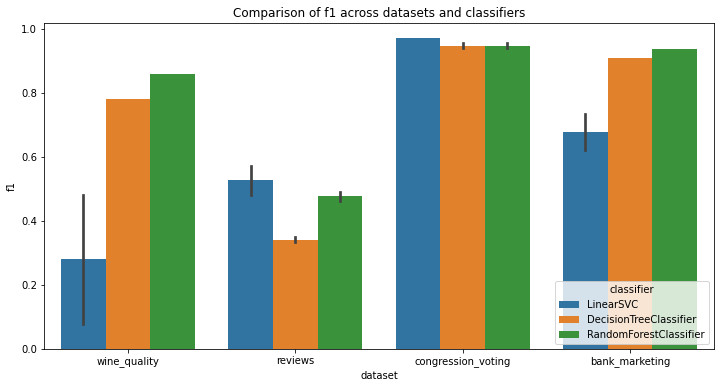

In [130]:
plt.figure(figsize=(12, 6))
sns.barplot(x='dataset', y='f1', hue='classifier', data=results_df)
plt.title('Comparison of f1 across datasets and classifiers')
plt.show()

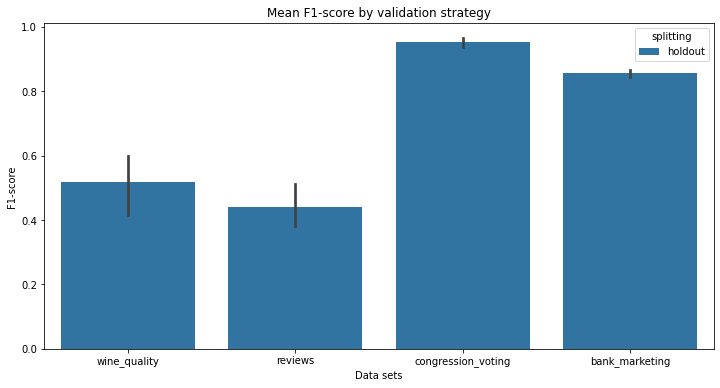

In [42]:
#plot f1-score across datasets for each classifier, cv vs holdout
plt.figure(figsize=(12, 6))
sns.barplot(x='dataset', y='f1', hue='splitting', data=results_df)
plt.title('Mean F1-score by validation strategy')
plt.ylabel('F1-score')
plt.xlabel('Data sets')
plt.show()

In [ ]:
# 
data.groupby(['dataset', 'Spliting'])['Mean F1-score'].mean().unstack().plot(kind='bar', figsize=(10,5))
plt.figure(figsize=(12, 6))
sns.barplot(x='dataset', y='f1', hue='spliting', data=results_df)
plt.title('Mean F1-score by validation strategy')
plt.ylabel('F1-score')
plt.xlabel('Data sets')
plt.show()